In [ ]:
!pip install cudaq
!pip install mpi4py
!pip install matplotlib
!pip install cudaq-solvers[gqe]
!pip install torch transformers lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 30.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 80.3 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 66.6 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 148.6 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 35.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 152.5 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 151.6 MB/s  0:00:010:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 152.5 MB/s  0:00:010:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 125.1 MB/s  0:00:00
   ━━━━━━━━━━━━

In [ ]:
import cudaq
import math
import numpy as np
import cudaq_solvers as solvers
from cudaq import spin
from cudaq_solvers.gqe_algorithm.gqe import get_default_config

# Target environment configuration
try:
    # Attempt to initialize NVIDIA multi-GPU target with double precision
    cudaq.set_target('nvidia', option="mqpu,fp64")
    print("Backend: NVIDIA GPU (mqpu)")
except:
    # Fallback to CPU simulator
    cudaq.set_target('qpp-cpu')
    print("Backend: QPP-CPU")

# ==========================================
# 1. Operator Pool with Geometric Primitives
# ==========================================

def get_interactions(N):
    """Generates 2-body and 4-body interaction indices for LABS Hamiltonian."""
    G2, G4 = [], []
    # G2: Pairwise interactions with relative offsets
    for i in range(1, N - 1): 
        for k in range(1, (N - i) // 2 + 1):
            G2.append([i - 1, i + k - 1])
    # G4: Four-body interactions with symmetric structure
    for i in range(1, N - 2):
        for t in range(1, (N - i - 1) // 2 + 1):
            for k in range(t + 1, N - i - t + 1):
                G4.append([i - 1, i + t - 1, i + k - 1, i + k + t - 1])
    return G2, G4

def labs_pool_with_metadata(N, depth_levels=4):
    """
    Constructs an operator pool containing geometric metadata.
    Essential for symmetry-based transfer learning.
    """
    G2, G4 = get_interactions(N)
    params = [math.pi / (2**i) for i in range(depth_levels)]
    
    pool = []
    metadata = [] 

    # Generate 2-body Operators with Gap metadata
    for idx_pair in G2:
        i, j = idx_pair
        gap = j - i
        base_op = spin.z(i) * spin.z(j)
        op = cudaq.SpinOperator(base_op)
        
        for p in params:
            # Positive rotation
            pool.append(p * op)
            metadata.append({'type': '2-body', 'gap': gap, 'coeff': p})
            # Negative rotation for bidirectional exploration
            pool.append(-p * op)
            metadata.append({'type': '2-body', 'gap': gap, 'coeff': -p})

    # Generate 4-body Operators with Relative Gap metadata
    for idx_quartet in G4:
        i, j, k, l = idx_quartet
        gaps = (j-i, k-j, l-k) # Geometric fingerprint
        base_op = spin.z(i) * spin.z(j) * spin.z(k) * spin.z(l)
        op = cudaq.SpinOperator(base_op)
        
        for p in params:
            pool.append(p * op)
            metadata.append({'type': '4-body', 'gaps': gaps, 'coeff': p})
            pool.append(-p * op)
            metadata.append({'type': '4-body', 'gaps': gaps, 'coeff': -p})
            
    return pool, metadata

def build_labs_hamiltonian(N):
    """Builds the target LABS Hamiltonian for the cost function."""
    G2, G4 = get_interactions(N)
    ham = 0
    for i, j in G2: ham += spin.z(i) * spin.z(j)
    for i, j, k, l in G4: ham += spin.z(i) * spin.z(j) * spin.z(k) * spin.z(l)
    return ham

# ==========================================
# 2. Transfer Engine: Feature Tiling Logic
# ==========================================

def transfer_and_expand(best_indices, source_metadata, N_target):
    """
    Maps optimized features from a source system to a target system 
    using a sliding window (Tiling) approach.
    """
    print(f"\n[Transfer] Mapping {len(best_indices)} features to N={N_target}...")
    
    expanded_coeffs = []
    expanded_words = []
    
    for idx in best_indices:
        feature = source_metadata[idx]
        theta = feature['coeff']
        
        if feature['type'] == '2-body':
            gap = feature['gap']
            # Apply feature tiling across the lattice
            for i in range(N_target - gap):
                j = i + gap
                s = ['I'] * N_target
                s[i], s[j] = 'Z', 'Z'
                word = cudaq.pauli_word("".join(s))
                expanded_coeffs.append(theta)
                expanded_words.append(word)
                
        elif feature['type'] == '4-body':
            g1, g2, g3 = feature['gaps']
            span = g1 + g2 + g3
            for i in range(N_target - span):
                j, k, l = i + g1, i + g1 + g2, i + g1 + g2 + g3
                s = ['I'] * N_target
                s[i], s[j], s[k], s[l] = 'Z', 'Z', 'Z', 'Z'
                word = cudaq.pauli_word("".join(s))
                expanded_coeffs.append(theta)
                expanded_words.append(word)
                
    print(f"[Transfer] Expansion complete. Total gates: {len(expanded_coeffs)}")
    return expanded_coeffs, expanded_words

# ==========================================
# 3. Execution Pipeline
# ==========================================

N_TRAIN = 15
N_TARGET = 30

# --- Phase 1: Source System Training (Small N) ---
print(f"=== Phase 1: GQE Training (N={N_TRAIN}) ===")
ham_train = build_labs_hamiltonian(N_TRAIN)
pool_train, meta_train = labs_pool_with_metadata(N_TRAIN)

def term_coefficients(op): return [term.evaluate_coefficient() for term in op]
def term_words(op, n): return [term.get_pauli_word(n) for term in op]

@cudaq.kernel
def kernel_train(n_qubits: int, coeffs: list[float], words: list[cudaq.pauli_word]):
    q = cudaq.qvector(n_qubits)
    h(q)
    for i in range(len(coeffs)):
        exp_pauli(coeffs[i], q, words[i])

def cost_train(sampled_ops, **kwargs):
    full_coeffs = [term_coefficients(op)[0].real for op in sampled_ops]
    full_words = [term_words(op, N_TRAIN)[0] for op in sampled_ops]
    return cudaq.observe(kernel_train, ham_train, N_TRAIN, full_coeffs, full_words).expectation()

# Execute GQE solver
cfg = get_default_config()
cfg.max_iters = 20
cfg.ngates = 100
cfg.verbose = False

minE, best_ops_idx = solvers.gqe(cost_train, pool_train, config=cfg)
print(f"Training complete. Identified {len(best_ops_idx)} dominant geometric features.")

# --- Phase 2: Symmetry-based Transfer ---
print(f"\n=== Phase 2: Feature Tiling Expansion (N={N_TARGET}) ===")
tl_coeffs, tl_words = transfer_and_expand(best_ops_idx, meta_train, N_TARGET)

# --- Phase 3: Inference & Sampling ---
print(f"\n=== Phase 3: Target System Sampling ===")

@cudaq.kernel
def kernel_target(n_qubits: int, coeffs: list[float], words: list[cudaq.pauli_word]):
    q = cudaq.qvector(n_qubits)
    h(q)
    # Circuit depth is scaled via transferred knowledge
    for i in range(len(coeffs)):
        exp_pauli(coeffs[i], q, words[i])

# Sample bitstrings to generate heuristic seeds for MTS
sample_results = cudaq.sample(kernel_target, N_TARGET, tl_coeffs, tl_words, shots_count=1000)

print("Top 5 Generated Seeds for MTS:")
for bitstring, count in list(sample_results.items())[:5]:
    print(f"{bitstring}: {count}")

Sampling complete: 1000 unique bitstrings from 2000 shots.
Top 5 most frequent samples: [('100111011011111011110010111111', 1), ('010111011111001111111100111111', 1), ('000110010100101101111100111111', 1), ('110000010100011000001100111111', 1), ('100010011000101011000111011111', 1)]
Converted 1000 candidates of length N=30.
Seed population size: 20
Best few seeded energies: [131, 147, 155, 155, 155]
Initial best energy: 267
Gen 1: New best energy = 83
Gen 6: New best energy = 67

Final best energy: 67
Best sequence: [ 1 -1 -1 -1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1
 -1 -1 -1 -1 -1 -1]
Initial best energy: 131
Gen 1: New best energy = 91
Gen 2: New best energy = 83
Gen 8: New best energy = 75
Gen 11: New best energy = 67

Final best energy: 67
Best sequence: [ 1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1
 -1  1  1 -1  1  1]

==================== COMPARISON ====================
Random init  best E:   67 | best seq: +---+++--++-++--+-+-++-+

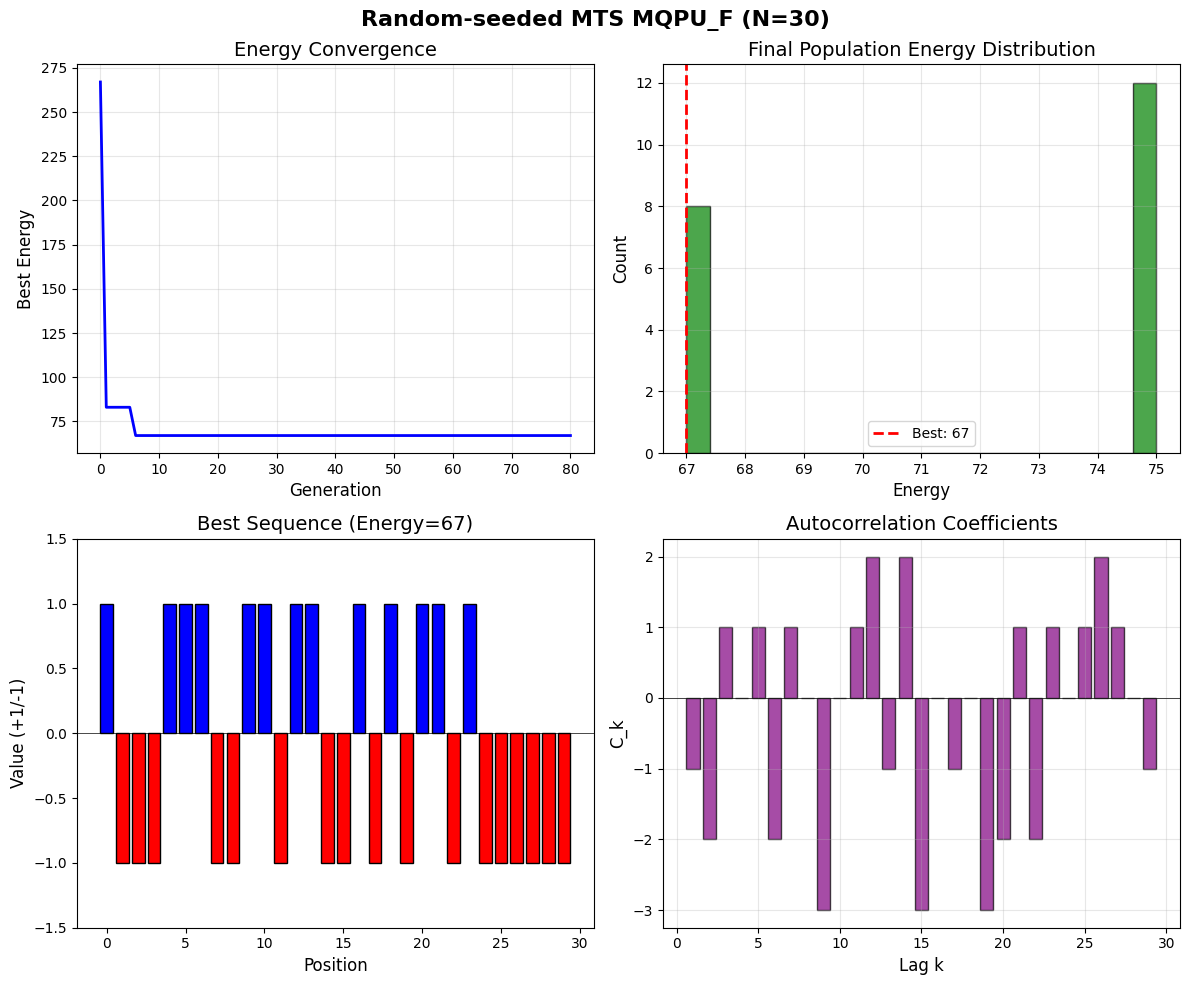

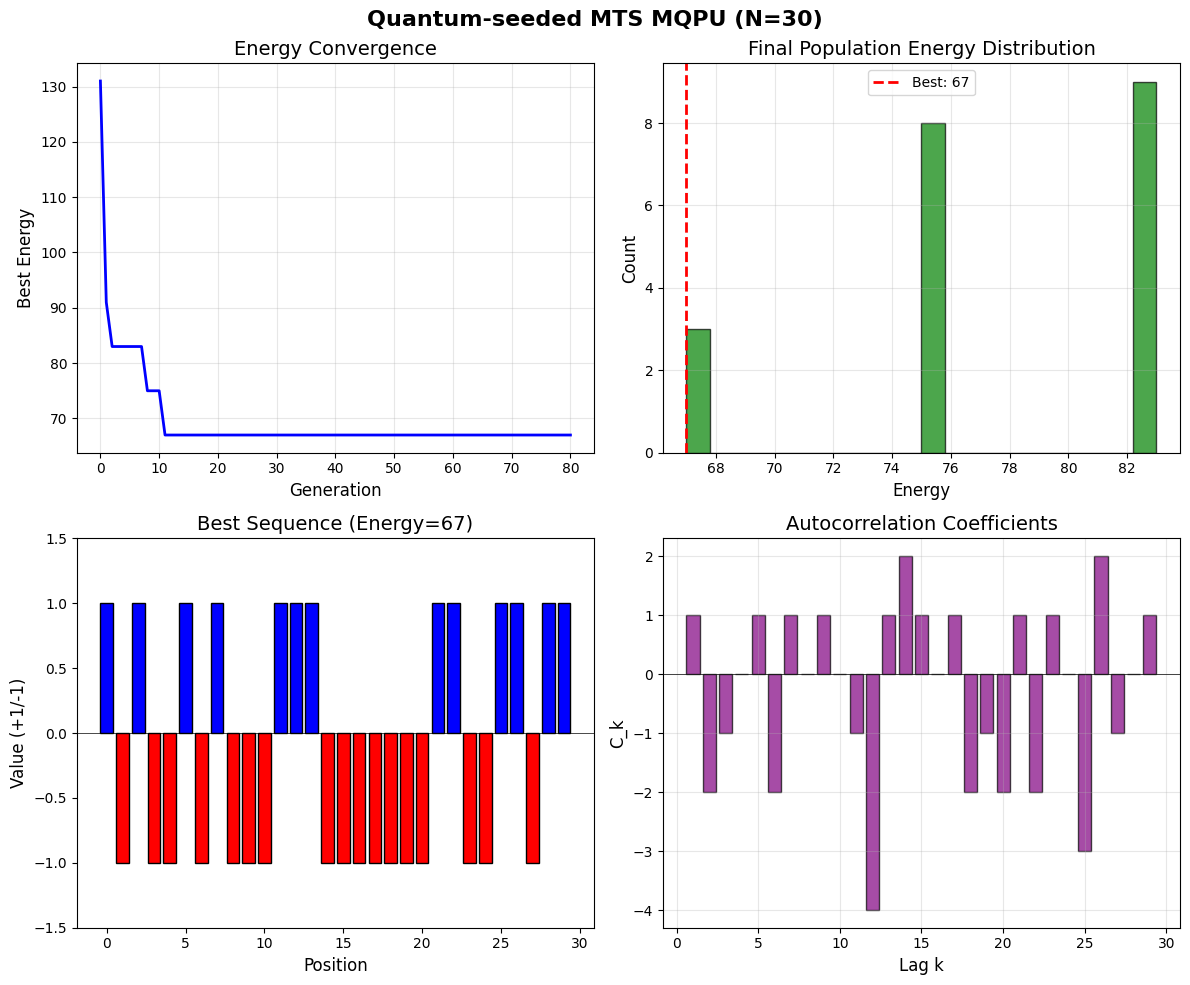

In [12]:
# Exercise 6: Quantum-seeded MTS population (fixed for Exercise 5 kernel)
# -------------------------------------------------------------
import inspect
import random
import numpy as np
import matplotlib.pyplot as plt


"""
Memetic Tabu Search (MTS) for the LABS Problem
===============================================
Implements the MTS algorithm as described in the paper:
"Scaling advantage with quantum-enhanced memetic tabu search for LABS"
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


# ============================================================================
# LABS Energy Functions
# ============================================================================

def compute_Ck(s: np.ndarray, k: int) -> int:
    """
    Compute the k-th autocorrelation coefficient C_k.
    C_k = sum_{i=1}^{N-k} s_i * s_{i+k}
    
    Args:
        s: Binary sequence of +1/-1 values
        k: Lag offset (1 to N-1)
    
    Returns:
        Autocorrelation value C_k
    """
    N = len(s)
    return int(np.sum(s[:N-k] * s[k:]))


def compute_energy(s: np.ndarray) -> int:
    """
    Compute the LABS energy E(s) = sum_{k=1}^{N-1} C_k^2
    
    Args:
        s: Binary sequence of +1/-1 values
    
    Returns:
        Energy value (lower is better)
    """
    N = len(s)
    energy = 0
    for k in range(1, N):
        Ck = compute_Ck(s, k)
        energy += Ck * Ck
    return energy


# ============================================================================
# MTS Helper Functions: Combine and Mutate
# ============================================================================

def combine(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    Combine two parent sequences using single-point crossover.
    Algorithm 3, Line 1-3 from the paper.
    
    Args:
        p1: First parent sequence
        p2: Second parent sequence
    
    Returns:
        Child sequence
    """
    N = len(p1)
    # Choose cut point k uniformly from {1, ..., N-1}
    k = np.random.randint(1, N)
    # Return p1[0:k] || p2[k:N]
    child = np.concatenate([p1[:k], p2[k:]])
    return child


def mutate(s: np.ndarray, p_mut: float) -> np.ndarray:
    """
    Mutate a sequence by flipping each bit with probability p_mut.
    Algorithm 3, Line 4-8 from the paper.
    
    Args:
        s: Input sequence
        p_mut: Mutation probability per bit
    
    Returns:
        Mutated sequence
    """
    s = s.copy()
    for i in range(len(s)):
        if np.random.random() < p_mut:
            s[i] = -s[i]  # Flip: +1 -> -1 or -1 -> +1
    return s


# ============================================================================
# Tabu Search Implementation
# ============================================================================

from typing import Tuple, Optional
import numpy as np

def tabu_search(
    s: np.ndarray,
    max_iter: int = 100,
    tabu_tenure: int = 7,
    use_gpu: bool = True,
    gpu_threads: int = 128,                 # kernel granularity knob (64/128/256)
    patience: Optional[int] = None,         # e.g., 20 -> stop if no global improvement
    return_history: bool = False
) -> Tuple[np.ndarray, int] | Tuple[np.ndarray, int, list]:
    """
    Tabu Search for LABS with optional GPU-parallel neighbor evaluation.

    - Evaluates all N single-flip neighbors each iteration
    - Applies tabu + aspiration
    - Selects best admissible move
    - Updates tabu list and global best

    Args:
        s: Starting sequence (+1/-1)
        max_iter: Maximum iterations
        tabu_tenure: How long a flipped index stays tabu
        use_gpu: If True, uses gpu_neighbor_energies()
        gpu_threads: Threads per block for the CuPy kernel (64/128/256)
        patience: Early stop if no global best improvement for this many iterations
        return_history: If True, return list of best energies over iterations

    Returns:
        (best_sequence, best_energy) or (best_sequence, best_energy, history)
    """
    N = len(s)
    current = s.copy()
    best = current.copy()

    current_energy = compute_energy(current)
    best_energy = current_energy

    # tabu_list[i] = iteration index until which move i is tabu (exclusive)
    tabu_list = np.zeros(N, dtype=np.int32)

    history = [best_energy]
    no_improve = 0

    for iteration in range(max_iter):
        # 1) Evaluate neighbor energies
        if use_gpu:
            neighbor_energies = gpu_neighbor_energies(current, threads=gpu_threads).astype(np.int64)
        else:
            neighbor_energies = np.empty(N, dtype=np.int64)
            for i in range(N):
                neighbor = current.copy()
                neighbor[i] = -neighbor[i]
                neighbor_energies[i] = compute_energy(neighbor)

        # 2) Tabu + aspiration mask
        is_tabu = tabu_list > iteration
        aspiration = neighbor_energies < best_energy
        admissible = (~is_tabu) | aspiration

        if not np.any(admissible):
            break

        # 3) Choose the best admissible neighbor (vectorized argmin)
        masked_E = np.where(admissible, neighbor_energies, np.iinfo(np.int64).max)
        best_flip_pos = int(np.argmin(masked_E))
        best_neighbor_energy = int(masked_E[best_flip_pos])

        # Safety: if argmin is max, no move exists
        if best_neighbor_energy == np.iinfo(np.int64).max:
            break

        # 4) Apply move
        current[best_flip_pos] = -current[best_flip_pos]
        current_energy = best_neighbor_energy

        # 5) Update tabu
        tabu_list[best_flip_pos] = iteration + tabu_tenure

        # 6) Update global best
        if current_energy < best_energy:
            best = current.copy()
            best_energy = current_energy
            no_improve = 0
        else:
            no_improve += 1

        history.append(best_energy)

        # 7) Optional early stop
        if patience is not None and no_improve >= patience:
            break

    if return_history:
        return best, best_energy, history
    return best, best_energy


# ============================================================================
# Main MTS Algorithm
# ============================================================================

def random_sequence(N: int) -> np.ndarray:
    """Generate a random binary sequence of +1/-1."""
    return np.random.choice([-1, 1], size=N)


def mts(N: int, 
        population_size: int = 20, 
        max_generations: int = 100,
        p_mut: float = 0.05,
        tabu_iter: int = 100,
        tabu_tenure: int = 7,
        initial_population: List[np.ndarray] = None,
        verbose: bool = True) -> Tuple[np.ndarray, int, List[np.ndarray], List[int]]:
    """
    Memetic Tabu Search for the LABS problem.
    
    Algorithm:
    1. Initialize population (random or provided)
    2. Find best solution in population
    3. For each generation:
       a. Select two parents from population
       b. Combine parents to create child
       c. Mutate child with probability p_mut
       d. Apply Tabu Search to child
       e. If result improves best, update and replace a random population member
    
    Args:
        N: Sequence length
        population_size: Number of sequences in population
        max_generations: Maximum number of generations
        p_mut: Mutation probability
        tabu_iter: Max iterations for tabu search
        tabu_tenure: Tabu tenure length
        initial_population: Optional initial population (for quantum seeding)
        verbose: Print progress
    
    Returns:
        Tuple of (best_sequence, best_energy, final_population, energy_history)
    """
    # Initialize population
    if initial_population is not None:
        population = [seq.copy() for seq in initial_population[:population_size]]
        # Fill remaining if needed
        while len(population) < population_size:
            population.append(random_sequence(N))
    else:
        population = [random_sequence(N) for _ in range(population_size)]
    
    # Compute initial energies
    energies = [compute_energy(s) for s in population]
    
    # Find initial best
    best_idx = np.argmin(energies)
    best = population[best_idx].copy()
    best_energy = energies[best_idx]
    
    energy_history = [best_energy]
    
    if verbose:
        print(f"Initial best energy: {best_energy}")
    
    # Main loop
    for gen in range(max_generations):
        # Select two parents (tournament selection)
        idx1, idx2 = np.random.choice(population_size, 2, replace=False)
        p1, p2 = population[idx1], population[idx2]
        
        # Combine
        child = combine(p1, p2)
        
        # Mutate
        child = mutate(child, p_mut)
        
        # Tabu Search
        child, child_energy = tabu_search(child, max_iter=tabu_iter, tabu_tenure=tabu_tenure)
        
        # Update population if child is better than worst
        worst_idx = np.argmax(energies)
        if child_energy < energies[worst_idx]:
            population[worst_idx] = child
            energies[worst_idx] = child_energy
        
        # Update global best
        if child_energy < best_energy:
            best = child.copy()
            best_energy = child_energy
            if verbose:
                print(f"Gen {gen+1}: New best energy = {best_energy}")
        
        energy_history.append(best_energy)
    
    if verbose:
        print(f"\nFinal best energy: {best_energy}")
        print(f"Best sequence: {best}")
    
    return best, best_energy, population, energy_history


# ============================================================================
# Visualization Functions
# ============================================================================

def visualize_results(population: List[np.ndarray], 
                      energy_history: List[int],
                      best_sequence: np.ndarray,
                      best_energy: int,
                      title: str = "MTS Results") -> plt.Figure:
    """
    Visualize MTS results including energy distribution and convergence.
    
    Args:
        population: Final population
        energy_history: Best energy at each generation
        best_sequence: Best sequence found
        best_energy: Best energy found
        title: Plot title
    
    Returns:
        matplotlib Figure object
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Energy convergence over generations
    ax1 = axes[0, 0]
    ax1.plot(energy_history, 'b-', linewidth=2)
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Best Energy', fontsize=12)
    ax1.set_title('Energy Convergence', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 2. Final population energy distribution
    ax2 = axes[0, 1]
    final_energies = [compute_energy(s) for s in population]
    ax2.hist(final_energies, bins=20, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(x=best_energy, color='red', linestyle='--', linewidth=2, label=f'Best: {best_energy}')
    ax2.set_xlabel('Energy', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Final Population Energy Distribution', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Best sequence visualization
    ax3 = axes[1, 0]
    N = len(best_sequence)
    colors = ['blue' if s == 1 else 'red' for s in best_sequence]
    ax3.bar(range(N), best_sequence, color=colors, edgecolor='black')
    ax3.set_xlabel('Position', fontsize=12)
    ax3.set_ylabel('Value (+1/-1)', fontsize=12)
    ax3.set_title(f'Best Sequence (Energy={best_energy})', fontsize=14)
    ax3.set_ylim(-1.5, 1.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 4. Autocorrelation of best sequence
    ax4 = axes[1, 1]
    Ck_values = [compute_Ck(best_sequence, k) for k in range(1, N)]
    ax4.bar(range(1, N), Ck_values, color='purple', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Lag k', fontsize=12)
    ax4.set_ylabel('C_k', fontsize=12)
    ax4.set_title('Autocorrelation Coefficients', fontsize=14)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


def sequence_to_string(s: np.ndarray) -> str:
    """Convert +1/-1 sequence to '+'/'-' string."""
    return ''.join(['+' if x == 1 else '-' for x in s])


# ============================================================================
# Example Usage
# ============================================================================

















# Assumes these already exist from previous cells:
# - cudaq imported
# - trotterized_circuit defined as trotterized_circuit(N, G2, G4, steps, thetas)
# - N, G2, G4, n_steps, thetas defined
# - mts, compute_energy, visualize_results, sequence_to_string imported


# ----------------------------
# 1) Sample your CUDA-Q kernel
# ----------------------------
shots = 2000           # increase if you want a cleaner distribution
population_size = 20


# Safely extract items (bitstring, count)
try:
    items = list(sample_results.items())
except Exception:
    items = list(dict(sample_results).items())

# Sort by frequency so we see the distribution clearly (optional but nice)
items.sort(key=lambda x: x[1], reverse=True)

print(f"Sampling complete: {len(items)} unique bitstrings from {shots} shots.")
print("Top 5 most frequent samples:", items[:5])


# -------------------------------------------
# 2) Bitstring -> ±1 numpy array (LABS format)
# -------------------------------------------
def bitstring_to_pm1_array(bs: str) -> np.ndarray:
    """
    Map measurement string to ±1:
      '0' -> +1
      '1' -> -1
    Returns np.ndarray of shape (N,).
    """
    return np.array([1 if b == "0" else -1 for b in bs], dtype=np.int8)

# Convert unique measured strings into candidates (keep uniqueness for diversity)
candidates = []
for bs, ct in items:
    if len(bs) != N:
        # If backend includes spaces or prefix, you might need to sanitize bs.
        # This is just a safety check.
        continue
    candidates.append(bitstring_to_pm1_array(bs))

print(f"Converted {len(candidates)} candidates of length N={N}.")


# ------------------------------------------------------------
# 3) Rank quantum candidates by classical LABS energy & seed pop
# ------------------------------------------------------------
# Compute energies once so we don't recompute in sorting repeatedly
cand_energies = [(seq, compute_energy(seq)) for seq in candidates]
cand_energies.sort(key=lambda x: x[1])  # low energy first

# Take best unique sequences (diverse seeding)
seed_pop = [seq for (seq, E) in cand_energies[:population_size]]

# If not enough unique quantum samples, fill remainder randomly
while len(seed_pop) < population_size:
    seed_pop.append(np.array([random.choice([-1, 1]) for _ in range(N)], dtype=np.int8))

print("Seed population size:", len(seed_pop))
print("Best few seeded energies:", [compute_energy(s) for s in seed_pop[:5]])


# ----------------------------------------
# 4) Run MTS: random init vs quantum init
# ----------------------------------------
mts_kwargs = dict(
    N=N,
    population_size=population_size,
    max_generations=80,
    p_mut=0.05,
    tabu_iter=100,
    tabu_tenure=7,
    verbose=True
)

# Baseline random
best_seq_rand, best_E_rand, final_pop_rand, hist_rand = mts(**mts_kwargs)

# Seeded run (your mts supports initial_population already)
sig = inspect.signature(mts)
if "initial_population" not in sig.parameters:
    raise RuntimeError("Your mts() does not support initial_population, but your pasted version should.")
best_seq_seed, best_E_seed, final_pop_seed, hist_seed = mts(
    **mts_kwargs,
    initial_population=seed_pop
)


# ---------------------------
# 5) Print + visualize results
# ---------------------------
print("\n==================== COMPARISON ====================")
print(f"Random init  best E: {best_E_rand:>4d} | best seq: {sequence_to_string(best_seq_rand)}")
print(f"Quantum init best E: {best_E_seed:>4d} | best seq: {sequence_to_string(best_seq_seed)}")

fig1 = visualize_results(final_pop_rand, hist_rand, best_seq_rand, best_E_rand,
                         f"Random-seeded MTS MQPU_F (N={N})")
fig2 = visualize_results(final_pop_seed, hist_seed, best_seq_seed, best_E_seed,
                         f"Quantum-seeded MTS MQPU (N={N})")

plt.show()
fig1.savefig("random_seeded_mts_MQPU.png", dpi=300, bbox_inches="tight")
fig2.savefig("quantum_seeded_mts_MQPU.png", dpi=300, bbox_inches="tight")

#-+-+----+----++-++--

In [14]:
!pip install matplotlib
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 89.7 MB/s  0:00:00


Sampling complete: 1000 unique bitstrings from 2000 shots.
Top 5 most frequent samples: [('100111011011111011110010111111', 1), ('010111011111001111111100111111', 1), ('000110010100101101111100111111', 1), ('110000010100011000001100111111', 1), ('100010011000101011000111011111', 1)]
Converted 1000 candidates of length N=30.
Seed population size: 20
Best few seeded energies: [131, 147, 155, 155, 155]
Initial best energy: 275
Gen 1: New best energy = 99
Gen 5: New best energy = 91
Gen 7: New best energy = 67

Final best energy: 67
Best sequence: [-1 -1 -1 -1  1  1  1  1  1 -1  1  1 -1  1  1 -1  1 -1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1  1]
Initial best energy: 131
Gen 1: New best energy = 91
Gen 2: New best energy = 83
Gen 11: New best energy = 75
Gen 12: New best energy = 67

Final best energy: 67
Best sequence: [ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1
  1  1 -1 -1  1  1]

==================== COMPARISON ====================
Random init  best E:   67 | best 

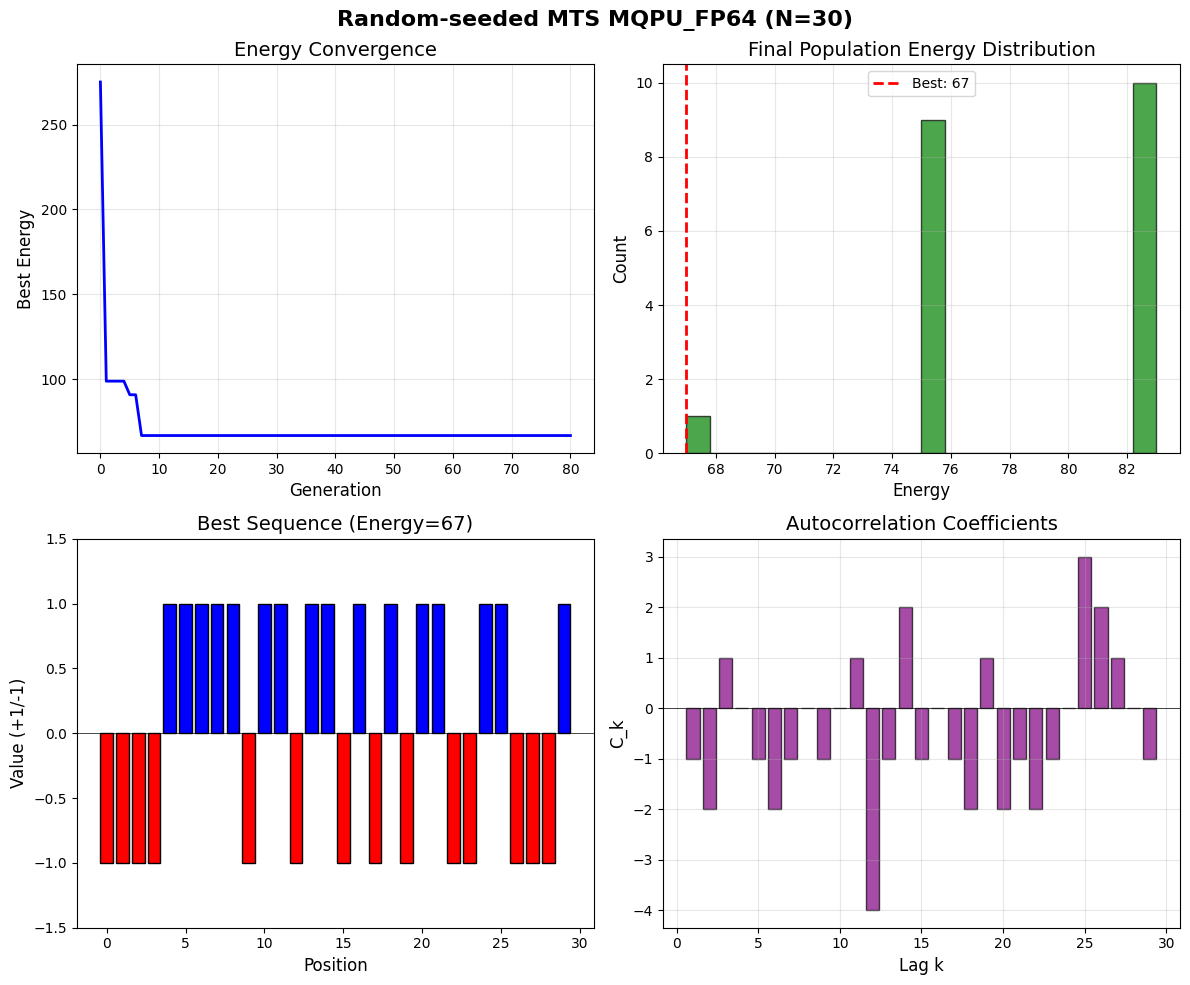

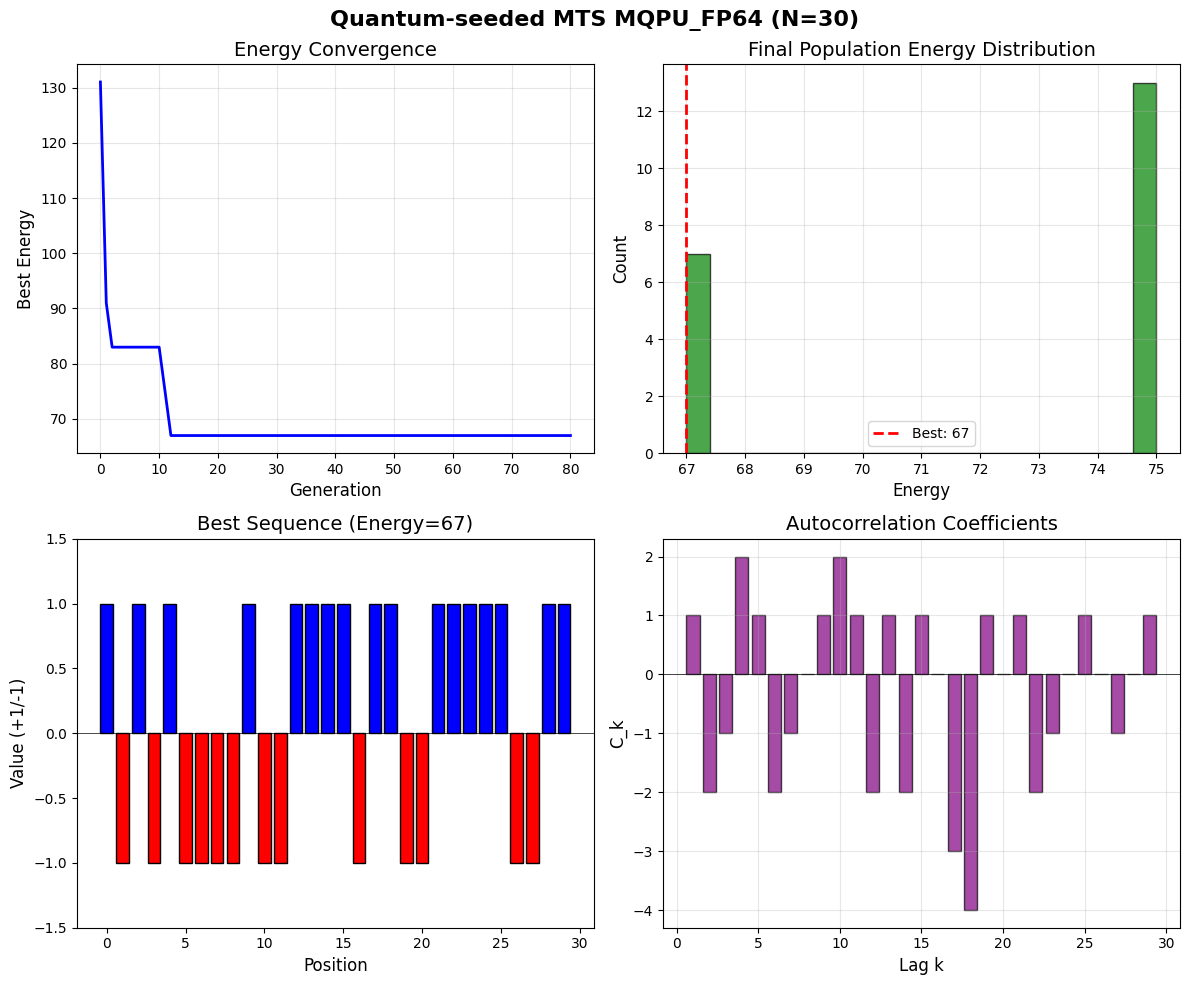

CPU neighbors: 0.0035905838012695312
GPU neighbors: 0.0008499622344970703
match: True


In [11]:
# CUPY IMPLEMENTATION TEST!!!! DONT NEED TO RUN THIS FOR NOW

#Exercise 6: Quantum-seeded MTS population (fixed for Exercise 5 kernel)
# -------------------------------------------------------------
import inspect
import random
import numpy as np
import matplotlib.pyplot as plt

import cupy as cp

NEIGHBOR_KERNEL = cp.RawKernel(r'''
extern "C" __global__
void labs_neighbor_energies(const signed char* s, int N, int* outE) {
    int p = blockIdx.x;
    int k = threadIdx.x + 1;
    if (k >= N) return;

    int Ck = 0;
    for (int i = 0; i < N - k; i++) {
        signed char a = s[i];
        signed char b = s[i + k];
        if (i == p) a = -a;
        if (i + k == p) b = -b;
        Ck += (int)a * (int)b;
    }
    atomicAdd(&outE[p], Ck * Ck);
}
''', 'labs_neighbor_energies')


"""
Memetic Tabu Search (MTS) for the LABS Problem
===============================================
Implements the MTS algorithm as described in the paper:
"Scaling advantage with quantum-enhanced memetic tabu search for LABS"
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


# ============================================================================
# LABS Energy Functions
# ============================================================================

def compute_Ck(s: np.ndarray, k: int) -> int:
    """
    Compute the k-th autocorrelation coefficient C_k.
    C_k = sum_{i=1}^{N-k} s_i * s_{i+k}
    
    Args:
        s: Binary sequence of +1/-1 values
        k: Lag offset (1 to N-1)
    
    Returns:
        Autocorrelation value C_k
    """
    N = len(s)
    return int(np.sum(s[:N-k] * s[k:]))


def compute_energy(s: np.ndarray) -> int:
    """
    Compute the LABS energy E(s) = sum_{k=1}^{N-1} C_k^2
    
    Args:
        s: Binary sequence of +1/-1 values
    
    Returns:
        Energy value (lower is better)
    """
    N = len(s)
    energy = 0
    for k in range(1, N):
        Ck = compute_Ck(s, k)
        energy += Ck * Ck
    return energy


# ============================================================================
# MTS Helper Functions: Combine and Mutate
# ============================================================================

def gpu_neighbor_energies(current: np.ndarray, threads: int = 128) -> np.ndarray:
    import cupy as cp

    s_gpu = cp.asarray(current.astype(cp.int8))
    N = int(s_gpu.size)
    outE = cp.zeros((N,), dtype=cp.int32)

    NEIGHBOR_KERNEL(
        (N,),              # grid: N blocks (one per flip)
        (threads,),        # threads per block
        (s_gpu, N, outE)
    )

    cp.cuda.Stream.null.synchronize()
    return cp.asnumpy(outE)


    
def combine(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    Combine two parent sequences using single-point crossover.
    Algorithm 3, Line 1-3 from the paper.
    
    Args:
        p1: First parent sequence
        p2: Second parent sequence
    
    Returns:
        Child sequence
    """
    N = len(p1)
    # Choose cut point k uniformly from {1, ..., N-1}
    k = np.random.randint(1, N)
    # Return p1[0:k] || p2[k:N]
    child = np.concatenate([p1[:k], p2[k:]])
    return child


def mutate(s: np.ndarray, p_mut: float) -> np.ndarray:
    """
    Mutate a sequence by flipping each bit with probability p_mut.
    Algorithm 3, Line 4-8 from the paper.
    
    Args:
        s: Input sequence
        p_mut: Mutation probability per bit
    
    Returns:
        Mutated sequence
    """
    s = s.copy()
    for i in range(len(s)):
        if np.random.random() < p_mut:
            s[i] = -s[i]  # Flip: +1 -> -1 or -1 -> +1
    return s


# ============================================================================
# Tabu Search Implementation
# ============================================================================
def tabu_search(s: np.ndarray, max_iter: int = 100, tabu_tenure: int = 7, use_gpu: bool = True):
    N = len(s)
    current = s.copy()
    current_energy = compute_energy(current)

    best = current.copy()
    best_energy = current_energy

    tabu_list = np.zeros(N, dtype=int)

    for iteration in range(max_iter):
        if use_gpu:
            neighbor_energies = gpu_neighbor_energies(current)  # shape (N,)
        else:
            # CPU fallback
            neighbor_energies = np.empty(N, dtype=int)
            for i in range(N):
                neighbor = current.copy()
                neighbor[i] = -neighbor[i]
                neighbor_energies[i] = compute_energy(neighbor)

        best_neighbor_energy = float('inf')
        best_flip_pos = -1

        # apply tabu + aspiration logic (CPU)
        for i in range(N):
            is_tabu = tabu_list[i] > iteration
            aspiration = neighbor_energies[i] < best_energy
            if (not is_tabu or aspiration) and neighbor_energies[i] < best_neighbor_energy:
                best_neighbor_energy = int(neighbor_energies[i])
                best_flip_pos = i

        if best_flip_pos == -1:
            break

        current[best_flip_pos] = -current[best_flip_pos]
        current_energy = best_neighbor_energy

        tabu_list[best_flip_pos] = iteration + tabu_tenure

        if current_energy < best_energy:
            best = current.copy()
            best_energy = current_energy

    return best, best_energy



# ============================================================================
# Main MTS Algorithm
# ============================================================================

def random_sequence(N: int) -> np.ndarray:
    """Generate a random binary sequence of +1/-1."""
    return np.random.choice([-1, 1], size=N)


def mts(N: int, 
        population_size: int = 20, 
        max_generations: int = 100,
        p_mut: float = 0.05,
        tabu_iter: int = 100,
        tabu_tenure: int = 7,
        initial_population: List[np.ndarray] = None,
        verbose: bool = True) -> Tuple[np.ndarray, int, List[np.ndarray], List[int]]:
    """
    Memetic Tabu Search for the LABS problem.
    
    Algorithm:
    1. Initialize population (random or provided)
    2. Find best solution in population
    3. For each generation:
       a. Select two parents from population
       b. Combine parents to create child
       c. Mutate child with probability p_mut
       d. Apply Tabu Search to child
       e. If result improves best, update and replace a random population member
    
    Args:
        N: Sequence length
        population_size: Number of sequences in population
        max_generations: Maximum number of generations
        p_mut: Mutation probability
        tabu_iter: Max iterations for tabu search
        tabu_tenure: Tabu tenure length
        initial_population: Optional initial population (for quantum seeding)
        verbose: Print progress
    
    Returns:
        Tuple of (best_sequence, best_energy, final_population, energy_history)
    """
    # Initialize population
    if initial_population is not None:
        population = [seq.copy() for seq in initial_population[:population_size]]
        # Fill remaining if needed
        while len(population) < population_size:
            population.append(random_sequence(N))
    else:
        population = [random_sequence(N) for _ in range(population_size)]
    
    # Compute initial energies
    energies = [compute_energy(s) for s in population]
    
    # Find initial best
    best_idx = np.argmin(energies)
    best = population[best_idx].copy()
    best_energy = energies[best_idx]
    
    energy_history = [best_energy]
    
    if verbose:
        print(f"Initial best energy: {best_energy}")
    
    # Main loop
    for gen in range(max_generations):
        # Select two parents (tournament selection)
        idx1, idx2 = np.random.choice(population_size, 2, replace=False)
        p1, p2 = population[idx1], population[idx2]
        
        # Combine
        child = combine(p1, p2)
        
        # Mutate
        child = mutate(child, p_mut)
        
        # Tabu Search
        child, child_energy = tabu_search(child, max_iter=tabu_iter, tabu_tenure=tabu_tenure)
        
        # Update population if child is better than worst
        worst_idx = np.argmax(energies)
        if child_energy < energies[worst_idx]:
            population[worst_idx] = child
            energies[worst_idx] = child_energy
        
        # Update global best
        if child_energy < best_energy:
            best = child.copy()
            best_energy = child_energy
            if verbose:
                print(f"Gen {gen+1}: New best energy = {best_energy}")
        
        energy_history.append(best_energy)
    
    if verbose:
        print(f"\nFinal best energy: {best_energy}")
        print(f"Best sequence: {best}")
    
    return best, best_energy, population, energy_history


# ============================================================================
# Visualization Functions
# ============================================================================

def visualize_results(population: List[np.ndarray], 
                      energy_history: List[int],
                      best_sequence: np.ndarray,
                      best_energy: int,
                      title: str = "MTS Results") -> plt.Figure:
    """
    Visualize MTS results including energy distribution and convergence.
    
    Args:
        population: Final population
        energy_history: Best energy at each generation
        best_sequence: Best sequence found
        best_energy: Best energy found
        title: Plot title
    
    Returns:
        matplotlib Figure object
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Energy convergence over generations
    ax1 = axes[0, 0]
    ax1.plot(energy_history, 'b-', linewidth=2)
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Best Energy', fontsize=12)
    ax1.set_title('Energy Convergence', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 2. Final population energy distribution
    ax2 = axes[0, 1]
    final_energies = [compute_energy(s) for s in population]
    ax2.hist(final_energies, bins=20, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(x=best_energy, color='red', linestyle='--', linewidth=2, label=f'Best: {best_energy}')
    ax2.set_xlabel('Energy', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Final Population Energy Distribution', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Best sequence visualization
    ax3 = axes[1, 0]
    N = len(best_sequence)
    colors = ['blue' if s == 1 else 'red' for s in best_sequence]
    ax3.bar(range(N), best_sequence, color=colors, edgecolor='black')
    ax3.set_xlabel('Position', fontsize=12)
    ax3.set_ylabel('Value (+1/-1)', fontsize=12)
    ax3.set_title(f'Best Sequence (Energy={best_energy})', fontsize=14)
    ax3.set_ylim(-1.5, 1.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 4. Autocorrelation of best sequence
    ax4 = axes[1, 1]
    Ck_values = [compute_Ck(best_sequence, k) for k in range(1, N)]
    ax4.bar(range(1, N), Ck_values, color='purple', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Lag k', fontsize=12)
    ax4.set_ylabel('C_k', fontsize=12)
    ax4.set_title('Autocorrelation Coefficients', fontsize=14)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


def sequence_to_string(s: np.ndarray) -> str:
    """Convert +1/-1 sequence to '+'/'-' string."""
    return ''.join(['+' if x == 1 else '-' for x in s])


# ============================================================================
# Example Usage
# ============================================================================



# Assumes these already exist from previous cells:
# - cudaq imported
# - trotterized_circuit defined as trotterized_circuit(N, G2, G4, steps, thetas)
# - N, G2, G4, n_steps, thetas defined
# - mts, compute_energy, visualize_results, sequence_to_string imported


# ----------------------------
# 1) Sample your CUDA-Q kernel
# ----------------------------
shots = 2000           # increase if you want a cleaner distribution
population_size = 20


# Safely extract items (bitstring, count)
try:
    items = list(sample_results.items())
except Exception:
    items = list(dict(sample_results).items())

# Sort by frequency so we see the distribution clearly (optional but nice)
items.sort(key=lambda x: x[1], reverse=True)

print(f"Sampling complete: {len(items)} unique bitstrings from {shots} shots.")
print("Top 5 most frequent samples:", items[:5])


# -------------------------------------------
# 2) Bitstring -> ±1 numpy array (LABS format)
# -------------------------------------------
def bitstring_to_pm1_array(bs: str) -> np.ndarray:
    """
    Map measurement string to ±1:
      '0' -> +1
      '1' -> -1
    Returns np.ndarray of shape (N,).
    """
    return np.array([1 if b == "0" else -1 for b in bs], dtype=np.int8)

# Convert unique measured strings into candidates (keep uniqueness for diversity)
candidates = []
for bs, ct in items:
    if len(bs) != N:
        # If backend includes spaces or prefix, you might need to sanitize bs.
        # This is just a safety check.
        continue
    candidates.append(bitstring_to_pm1_array(bs))

print(f"Converted {len(candidates)} candidates of length N={N}.")


# ------------------------------------------------------------
# 3) Rank quantum candidates by classical LABS energy & seed pop
# ------------------------------------------------------------
# Compute energies once so we don't recompute in sorting repeatedly
cand_energies = [(seq, compute_energy(seq)) for seq in candidates]
cand_energies.sort(key=lambda x: x[1])  # low energy first

# Take best unique sequences (diverse seeding)
seed_pop = [seq for (seq, E) in cand_energies[:population_size]]

# If not enough unique quantum samples, fill remainder randomly
while len(seed_pop) < population_size:
    seed_pop.append(np.array([random.choice([-1, 1]) for _ in range(N)], dtype=np.int8))

print("Seed population size:", len(seed_pop))
print("Best few seeded energies:", [compute_energy(s) for s in seed_pop[:5]])


# ----------------------------------------
# 4) Run MTS: random init vs quantum init
# ----------------------------------------
mts_kwargs = dict(
    N=N,
    population_size=population_size,
    max_generations=80,
    p_mut=0.05,
    tabu_iter=100,
    tabu_tenure=7,
    verbose=True
)

# Baseline random
best_seq_rand, best_E_rand, final_pop_rand, hist_rand = mts(**mts_kwargs)

# Seeded run (your mts supports initial_population already)
sig = inspect.signature(mts)
if "initial_population" not in sig.parameters:
    raise RuntimeError("Your mts() does not support initial_population, but your pasted version should.")
best_seq_seed, best_E_seed, final_pop_seed, hist_seed = mts(
    **mts_kwargs,
    initial_population=seed_pop
)


# ---------------------------
# 5) Print + visualize results
# ---------------------------
print("\n==================== COMPARISON ====================")
print(f"Random init  best E: {best_E_rand:>4d} | best seq: {sequence_to_string(best_seq_rand)}")
print(f"Quantum init best E: {best_E_seed:>4d} | best seq: {sequence_to_string(best_seq_seed)}")

fig1 = visualize_results(final_pop_rand, hist_rand, best_seq_rand, best_E_rand,
                         f"Random-seeded MTS MQPU_FP64 (N={N})")
fig2 = visualize_results(final_pop_seed, hist_seed, best_seq_seed, best_E_seed,
                         f"Quantum-seeded MTS MQPU_FP64 (N={N})")

plt.show()
fig1.savefig("random_seeded_mts_MQPU_FP64.png", dpi=300, bbox_inches="tight")
fig2.savefig("quantum_seeded_mts_MQPU_FP64.png", dpi=300, bbox_inches="tight")



import time

x = random_sequence(N)

t0 = time.time()
E_cpu = []
for i in range(N):
    y = x.copy(); y[i] *= -1
    E_cpu.append(compute_energy(y))
print("CPU neighbors:", time.time() - t0)

t0 = time.time()
E_gpu = gpu_neighbor_energies(x)
cp.cuda.Stream.null.synchronize()
print("GPU neighbors:", time.time() - t0)

print("match:", np.allclose(np.array(E_cpu), E_gpu))



#-+-+----+----++-++--